In [1]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
plt.rc('text', usetex=True)

from astropy.table import Table

import glob
import os
import pickle



# #---------------------------------------------------------------------------#
from colossus.halo import mass_adv
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

In [2]:
def load_pkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle

    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)
        pklFile.close()

        return data
    else:
        warnings.warn("## Can not find %s, return None" % filename)
        return None

def hsc_quantity_in_bin(hsc_gals, mass_bins, quantity, mass_type):
    '''
    returns hsc quantity (e.g. profiles) in given mass bin
    '''
    
    #halo mass bins
    n_bins = len(mass_bins) - 1
    
    profiles_in_bins=[]
    
    if mass_type == 'vir':
        masses = hsc_gals['logmh_vir_symbol']
    elif mass_type == 'm100':
        masses = hsc_gals['logm_100']
    
    for bin in range(n_bins):
        lower = mass_bins[bin]
        upper = mass_bins[bin+1]
        
        sbps = hsc_gals[quantity][(masses>lower) & (masses<upper)]
        
        profiles_in_bins.append(sbps)
        
    return profiles_in_bins


In [3]:
################################################################################
#HSC
hsc_data='/Users/fardila/Documents/Github/HSC_vs_hydro/Data/HSC/'
hscMedProf_114_116 = np.load(hsc_data+'s16a_wide2_massive_logm100_11.4_11.6.medprof.npy')[0]
hscMedProf_116_118 = np.load(hsc_data+'s16a_wide2_massive_logm100_11.6_11.8.medprof.npy')[0]
hscMedProf_118_120 = np.load(hsc_data+'s16a_wide2_massive_logm100_11.8_12.0.medprof.npy')[0]

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)

#masses
hsc_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_mass_good_mhalo_frac4_180503.fits'
hsc_table = Table.read(hsc_file)

# These are the median stellar mass density profiles for HSC galaxies at 0.3 < z < 0.5
# in three mass bins
# rm0 : 11.4 < logM_100kpc < 11.6
# rm1 : 11.6 < logM_100kpc < 11.8
# rm2 : 11.8 < logM_100kpc < 12.0
# They are on a common radius array, and we use (r ** 0.25) as radius

In [4]:
#open pickels
tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/tng_isos_merged.pkl'

def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

tng_masses = open_pkl(tng_masses_file)
tng_isos = open_pkl(tng_isos_file)


In [5]:
TNG_file_highres = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2_highres.hdf5'
f = h5py.File(TNG_file_highres, 'r')
map_size = f['config'].attrs['map_range_min']
n_pixels = f['config'].attrs['map_npixel']
pixel_scale_highres=2 * (map_size/n_pixels)
f.close()

print 'pixel scale: ', pixel_scale_highres
print map_size, n_pixels

pixel scale:  1.0
150.0 300


In [6]:
nbin=150
def get_median_profile(isos, pixel_scale, quantity = 'intens', rmin=0.05, rmax=4.7, nbin=nbin):
    """Get the median profiles."""
    sma_common = np.linspace(rmin, rmax, nbin)
    
    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)
    if quantity == 'intens_kpc':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)


    return sma_common, mu

# match by M100

## HSC 

In [7]:
#stellar mass bins
stellar_mass_bins = np.linspace(11.6,12.0,3)
#profile
hsc_profiles = hsc_quantity_in_bin(hsc_table, stellar_mass_bins, quantity='sbp', mass_type='m100')

#curve of growth (cog)
hsc_cog = hsc_quantity_in_bin(hsc_table, [11.6,12.0], quantity='cog', mass_type='m100')

hsc_sma = np.arange(0.4, 4.2, 0.01)

In [8]:
#mass range1
tng_isos1=[]
ngals1=0

#mass range2
tng_isos2=[]
ngals2=0

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log10


18 12


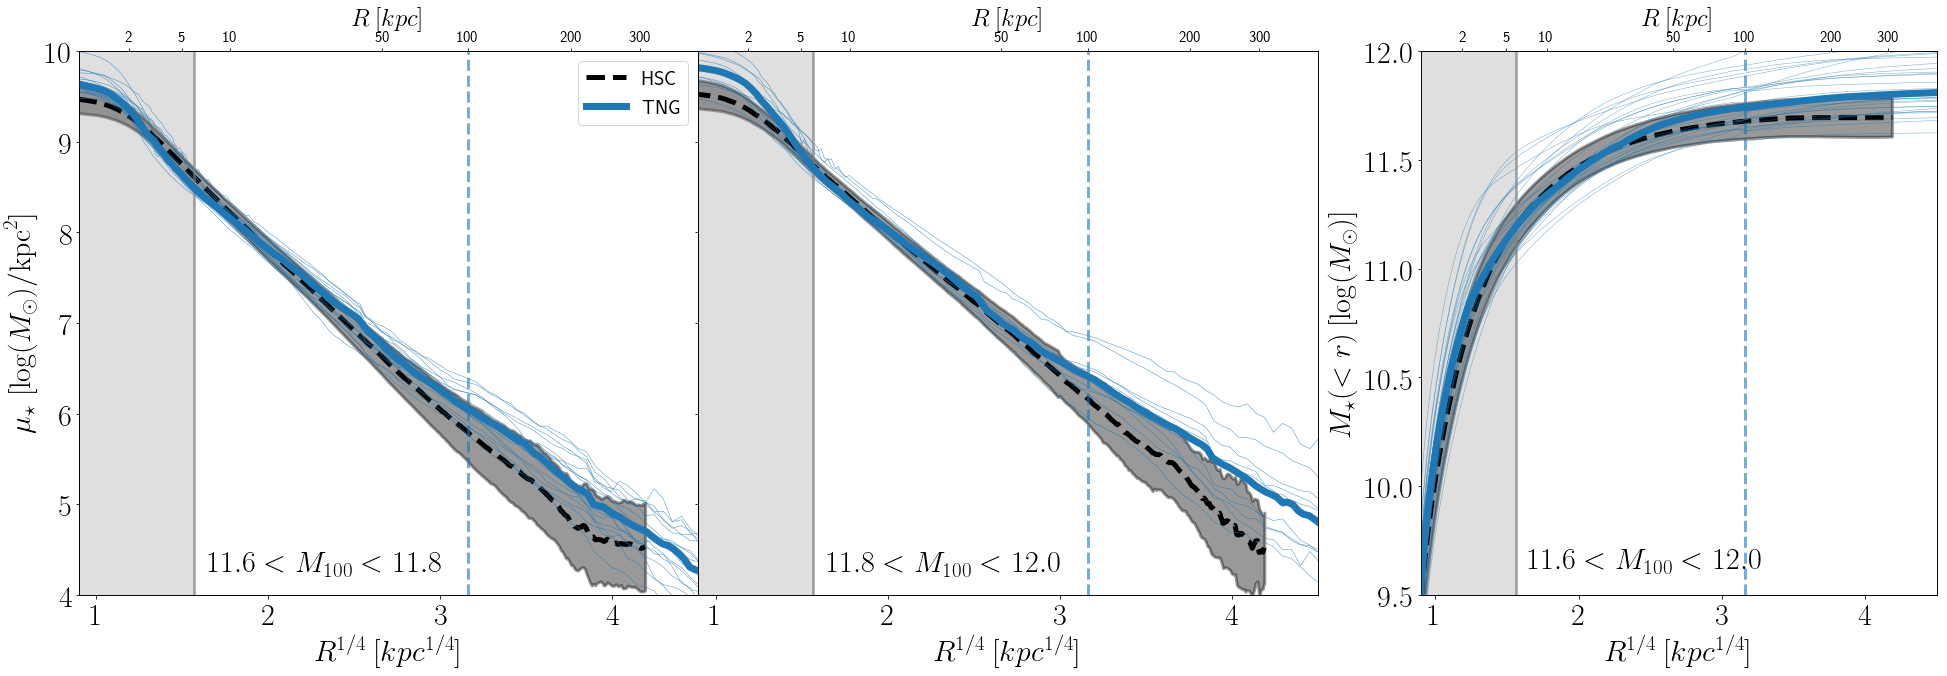

In [44]:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=False, figsize=(10*3, 10))
# fig.subplots_adjust(left=0.22, right=0.995, bottom=0.14, top=0.94, wspace=0.00, hspace=0.00)
fig = plt.figure(figsize=(10*6, 10))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(left=0.05, right=0.48, wspace=0.0)
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1])
gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.05, right=0.48, wspace=0.3)
ax3 = plt.subplot(gs2[0, -1])


######################################################################################################################
# plot
######################################################################################################################
#HSC
#medians
hsc_median1 = np.nanmedian(hsc_profiles[0], axis=0)
hsc_median2 = np.nanmedian(hsc_profiles[1], axis=0)
hsc_median_cog = np.nanmedian(hsc_cog[0], axis=0)

#stds (masked_invalid to exclude infinities)
hsc_std1 = np.nanstd(np.ma.masked_invalid(hsc_profiles[0]),axis=0)
hsc_std2 = np.nanstd(np.ma.masked_invalid(hsc_profiles[1]),axis=0)
hsc_std_cog = np.nanstd(np.ma.masked_invalid(hsc_cog[0]),axis=0)

# ax1.plot(RSMA_COMMON, hscMedProf_116_118, linestyle='--', linewidth=5.0, c='k',
#          alpha=1, zorder=2, label='HSC')
# ax2.plot(RSMA_COMMON, hscMedProf_118_120, linestyle='--', linewidth=5.0, c='k',
#          alpha=1, zorder=2, label='HSC')
ax1.plot(hsc_sma, hsc_median1, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
ax2.plot(hsc_sma, hsc_median2, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
ax3.plot(hsc_sma, median_hsc_cog, linestyle='--', linewidth=5.0, c='k',
         alpha=1, zorder=2, label='HSC')

ax1.fill_between(hsc_sma, hsc_median1+hsc_std1, hsc_median1-hsc_std1, 
                 alpha=0.4, color='k', zorder=1, linewidth=3)
ax2.fill_between(hsc_sma, hsc_median2+hsc_std2, hsc_median2-hsc_std2, 
                 alpha=0.4, color='k', zorder=1, linewidth=3)
ax3.fill_between(hsc_sma, hsc_median_cog+hsc_std_cog, hsc_median_cog-hsc_std_cog, 
                 alpha=0.4, color='k', zorder=1, linewidth=3)
                 
##TNG
for masses, iso in zip(tng_masses, tng_isos):   
    
#     cat_mass = masses[0] 
#     summed_mass = galaxy[2] 
#     fit_mass = iso_tng['mag_tot'][0]/-2.5 
    m_100_1d = masses['m_1d_100'] 
    
    
    if (m_100_1d<11.6) or (m_100_1d>12.0):
        continue

    elif (m_100_1d>=11.6) and (m_100_1d<11.8):
        ngals1+=1

        tng_isos1.append(iso)

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.8, 
                 label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))
            
        #cumulative mass  
        ax3.plot((iso['sma_kpc']) ** 0.25,
             np.log10(iso['growth_ori']), linewidth=0.5, c=u'#1f77b4', alpha=0.6, label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))

        
    elif (m_100_1d>=11.8) and (m_100_1d<12.0):
        ngals2+=1
        
        tng_isos2.append(iso)

        ax2.plot((iso['sma_kpc']) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0), linewidth=0.5, c=u'#1f77b4', alpha=0.8, 
                 label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))

        #cumulative mass
        ax3.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['growth_ori']), linewidth=0.5, c=u'#1f77b4', alpha=0.6, label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


## median profiles for tng
median_sma1, median_mu1 = get_median_profile(tng_isos1, pixel_scale = 0, quantity = 'intens_kpc')
median_sma2, median_mu2 = get_median_profile(tng_isos2, pixel_scale = 0, quantity = 'intens_kpc')
median_sma, median_mu = get_median_profile(tng_isos1+tng_isos2, 
                                           pixel_scale = 0, quantity='growth_ori')

ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=7.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=5)
ax2.plot(median_sma2, median_mu2+ np.log10(0.7 ** 2.0), linewidth=7.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=5)
ax3.plot(median_sma, median_mu, linewidth=7.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=5)



print ngals1, ngals2


######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 4.5)
ax1.set_ylim(4, 10)
ax2.set_xlim(0.9, 4.5)
ax2.set_ylim(4, 10)
ax3.set_xlim(0.9, 4.5)
ax3.set_ylim(9.5, 12)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='x', which='major', labelsize=30)
ax3.tick_params(axis='both', which='major', labelsize=30)

# #ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)
# ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#text label
ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)
ax2.text(1.65, 4.2, r'$11.8<M_{100}<12.0$', size=30)
ax3.text(1.65, 9.6, r'$11.6<M_{100}<12.0$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax2_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax2_twin.tick_params(axis='both', which='major', labelsize=15)
ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

x1, x2 = ax3.get_xlim()
ax3_twin = ax3.twiny()
ax3_twin.set_xlim(x1, x2)
ax3_twin.figure.canvas.draw()
ax3_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax3_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax3_twin.tick_params(axis='both', which='major', labelsize=15)
ax3_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)


######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax3.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax3.set_ylabel(r'$M_{\star}( < r ) \: [ \log (M_{\odot})]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey')
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey')
ax3.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax3.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey')

#grey out psf region
ax1.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax2.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax3.axvspan(0, 6**0.25, alpha=0.25, color='grey')
######################################################################################################################
#adjustments to ticks and space between subplots

#plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels()[0], visible=False)

#remove last label in x-axis of ax1 to prevent overlaping of labels with ax2
labels1 = [item.get_text() for item in ax2.get_xticklabels()[:-1]]
ax1.set_xticklabels(labels1)

#add a bit of space between subplots
# plt.tight_layout()

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_TNG.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## 3 mass bins no curve of growth 

In [11]:
#stellar mass bins
stellar_mass_bins = np.linspace(11.4,12.0,4)
#profile
hsc_profiles = hsc_quantity_in_bin(hsc_table, stellar_mass_bins, quantity='sbp', mass_type='m100')

/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


59 18 12


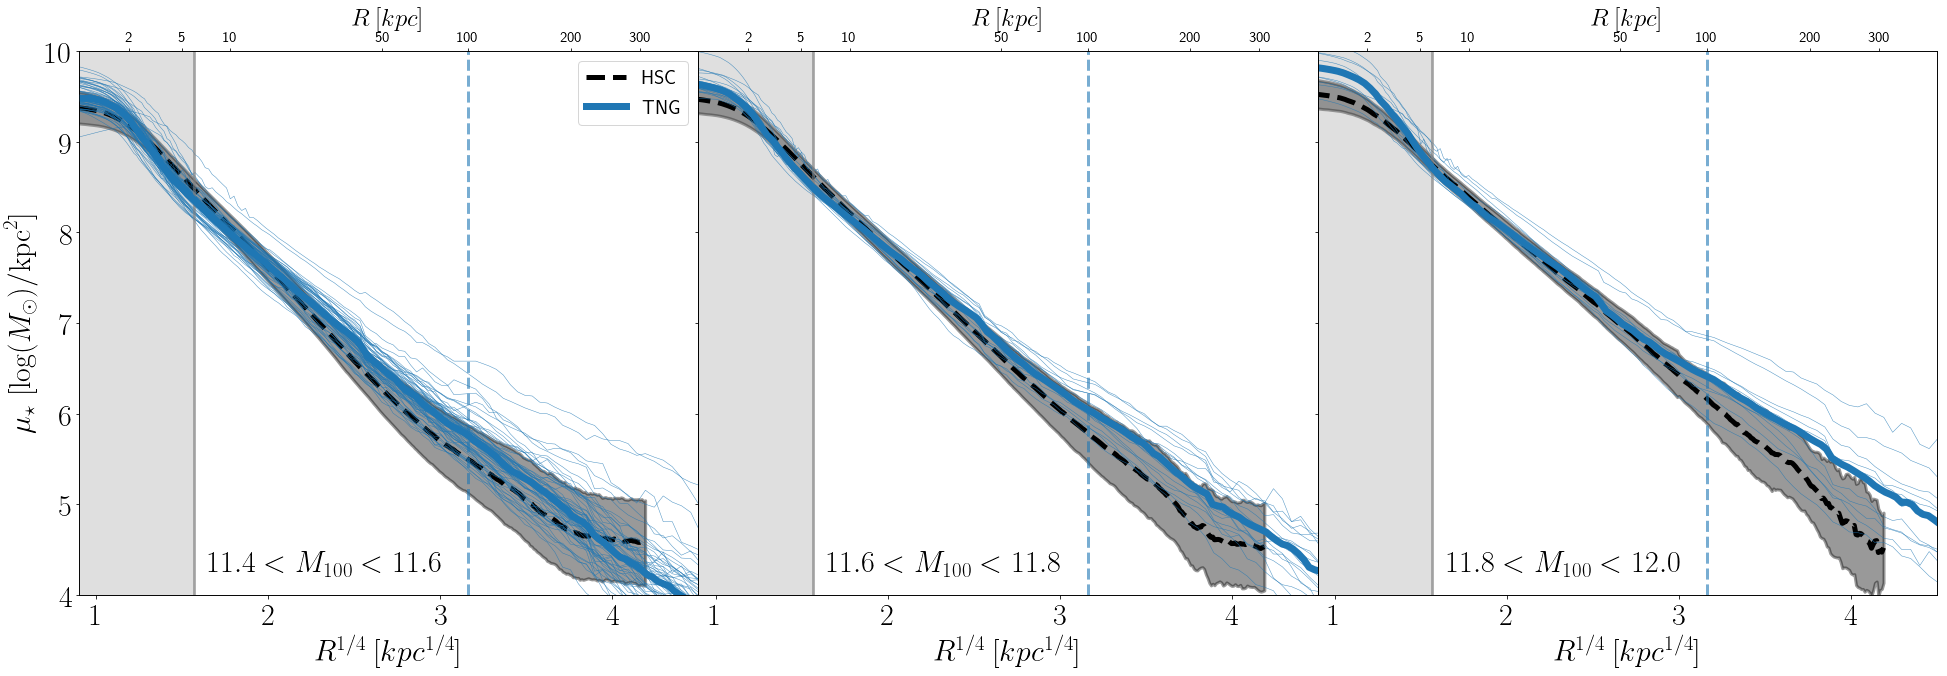

In [21]:
#mass range1
tng_isos1=[]
ngals1=0

#mass range2
tng_isos2=[]
ngals2=0

#mass range3
tng_isos3=[]
ngals3=0

# PLOT
fig = plt.figure(figsize=(10*6, 10))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(left=0.05, right=0.48, wspace=0.0)
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1])
gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.05, right=0.48, wspace=0.0)
ax3 = plt.subplot(gs2[0, -1])


######################################################################################################################
# plot
######################################################################################################################
#HSC
#medians
hsc_median1 = np.nanmedian(hsc_profiles[0], axis=0)
hsc_median2 = np.nanmedian(hsc_profiles[1], axis=0)
hsc_median3 = np.nanmedian(hsc_profiles[2], axis=0)

#stds (masked_invalid to exclude infinities)
hsc_std1 = np.nanstd(np.ma.masked_invalid(hsc_profiles[0]),axis=0)
hsc_std2 = np.nanstd(np.ma.masked_invalid(hsc_profiles[1]),axis=0)
hsc_std3 = np.nanstd(np.ma.masked_invalid(hsc_profiles[2]),axis=0)

ax1.plot(hsc_sma, hsc_median1, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
ax2.plot(hsc_sma, hsc_median2, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
ax3.plot(hsc_sma, hsc_median3, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')

ax1.fill_between(hsc_sma, hsc_median1+hsc_std1, hsc_median1-hsc_std1, 
                 alpha=0.4, color='k', zorder=1, linewidth=3)
ax2.fill_between(hsc_sma, hsc_median2+hsc_std2, hsc_median2-hsc_std2, 
                 alpha=0.4, color='k', zorder=1, linewidth=3)
ax3.fill_between(hsc_sma, hsc_median3+hsc_std3, hsc_median3-hsc_std3, 
                 alpha=0.4, color='k', zorder=1, linewidth=3)
                 
##TNG
for masses, iso in zip(tng_masses, tng_isos):   
    
#     cat_mass = masses[0] 
#     summed_mass = galaxy[2] 
#     fit_mass = iso_tng['mag_tot'][0]/-2.5 
    m_100_1d = masses['m_1d_100'] 
    
    
    if (m_100_1d<11.4) or (m_100_1d>12.0):
        continue
    elif (m_100_1d>=11.4) and (m_100_1d<11.6):
        ngals1+=1

        tng_isos1.append(iso)

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.8, 
                 label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))

        
    elif (m_100_1d>=11.6) and (m_100_1d<11.8):
        ngals2+=1

        tng_isos2.append(iso)

        ax2.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.8, 
                 label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))
            
        
    elif (m_100_1d>=11.8) and (m_100_1d<12.0):
        ngals3+=1
        
        tng_isos3.append(iso)

        ax3.plot((iso['sma_kpc']) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0), linewidth=0.5, c=u'#1f77b4', alpha=0.8, 
                 label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))

## median profiles for tng
median_sma1, median_mu1 = get_median_profile(tng_isos1, pixel_scale = 0, quantity = 'intens_kpc')
median_sma2, median_mu2 = get_median_profile(tng_isos2, pixel_scale = 0, quantity = 'intens_kpc')
median_sma3, median_mu3 = get_median_profile(tng_isos3, pixel_scale = 0, quantity='intens_kpc')

ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=7.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=5)
ax2.plot(median_sma2, median_mu2+ np.log10(0.7 ** 2.0), linewidth=7.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=5)
ax3.plot(median_sma3, median_mu3+ np.log10(0.7 ** 2.0), linewidth=7.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=5)



print ngals1, ngals2, ngals3


######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 4.5)
ax1.set_ylim(4, 10)
ax2.set_xlim(0.9, 4.5)
ax2.set_ylim(4, 10)
ax3.set_xlim(0.9, 4.5)
ax3.set_ylim(4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='x', which='major', labelsize=30)
ax3.tick_params(axis='both', which='major', labelsize=30)

# #ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)
# ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#text label
ax1.text(1.65, 4.2, r'$11.4<M_{100}<11.6$', size=30)
ax2.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)
ax3.text(1.65, 4.2, r'$11.8<M_{100}<12.0$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax2_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax2_twin.tick_params(axis='both', which='major', labelsize=15)
ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

x1, x2 = ax3.get_xlim()
ax3_twin = ax3.twiny()
ax3_twin.set_xlim(x1, x2)
ax3_twin.figure.canvas.draw()
ax3_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax3_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax3_twin.tick_params(axis='both', which='major', labelsize=15)
ax3_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)


######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax3.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
# ax3.set_ylabel(r'$M_{\star}( < r ) \: [ \log (M_{\odot})]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey')
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey')
ax3.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax3.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey')

#grey out psf region
ax1.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax2.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax3.axvspan(0, 6**0.25, alpha=0.25, color='grey')
######################################################################################################################
#adjustments to ticks and space between subplots

#plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels()[0], visible=False)

#remove last label in x-axis of ax1 to prevent overlaping of labels with ax2
labels1 = [item.get_text() for item in ax2.get_xticklabels()[:-1]]
ax1.set_xticklabels(labels1)

#add a bit of space between subplots
# plt.tight_layout()

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/profiles_matched_by_stellar_mass_TNG.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## match by M_halo

In [15]:
#mass bins
mass_bins = np.linspace(13.0,14.25,4)

In [16]:
hsc_m_dm_sr = hsc_table['logmh_vir_symbol']
hsc_m_dm_rf = hsc_table['logmh_vir_forest']

hsc_m100 = hsc_table['logm_100']

hsc_profiles = hsc_quantity_in_bin(hsc_table, mass_bins, quantity='sbp', mass_type='vir')
hsc_sma = np.arange(0.4, 4.2, 0.01)

In [17]:
f = h5py.File(TNG_file_highres, 'r')
tng_m_200c = np.array(f['catgrp_Group_M_Crit200'])
z_tng = f['config'].attrs['snap_z']

#convert to Mvir
tng_m_vir, _, _ = mass_adv.changeMassDefinitionCModel(tng_m_200c, z_tng, '200c', 'vir',
                                                                      profile='nfw', c_model='diemer19')
log_tng_m_vir = np.log10(tng_m_vir)


f.close()

## catalog mass is the same in quick and highres maps 

In [23]:
#mass range 1
tng_isos1=[]
ngals1=0

#mass range 2
tng_isos2=[]
ngals2=0

#mass range 3
tng_isos3=[]
ngals3=0

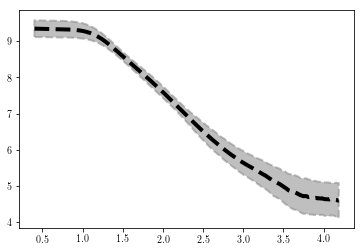

In [16]:
# for profile in random.sample(hsc_profiles[0],1000):
#     plt.plot(hsc_sma, profile, linewidth=0.5, c='grey', linestyle='-',
#          alpha=0.2, zorder=1, label='_nolegend_')
plt.plot(hsc_sma, np.nanmedian(hsc_profiles[0], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')
plt.fill_between(hsc_sma, np.nanmedian(hsc_profiles[0], axis=0)+np.nanstd(np.ma.masked_invalid(hsc_profiles[0]),axis=0),
                 np.nanmedian(hsc_profiles[0], axis=0)-np.nanstd(np.ma.masked_invalid(hsc_profiles[0]),axis=0),
                 alpha=0.5, color='grey', zorder=4, linewidth=2, linestyle='--')

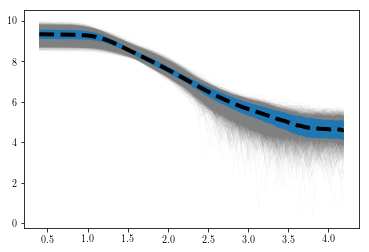

In [72]:
for profile in hsc_profiles[0]:
    plt.plot(hsc_sma, profile, linewidth=0.5, c='grey', linestyle='-',
         alpha=0.05, zorder=1, label='_nolegend_')
plt.plot(hsc_sma, np.nanmedian(hsc_profiles[0], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')
plt.fill_between(hsc_sma, np.nanmedian(hsc_profiles[0], axis=0)+np.nanstd(np.ma.masked_invalid(hsc_profiles[0]),axis=0),
                 np.nanmedian(hsc_profiles[0], axis=0)-np.nanstd(np.ma.masked_invalid(hsc_profiles[0]),axis=0),
                 zorder=4, linewidth=3)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


82 35 13


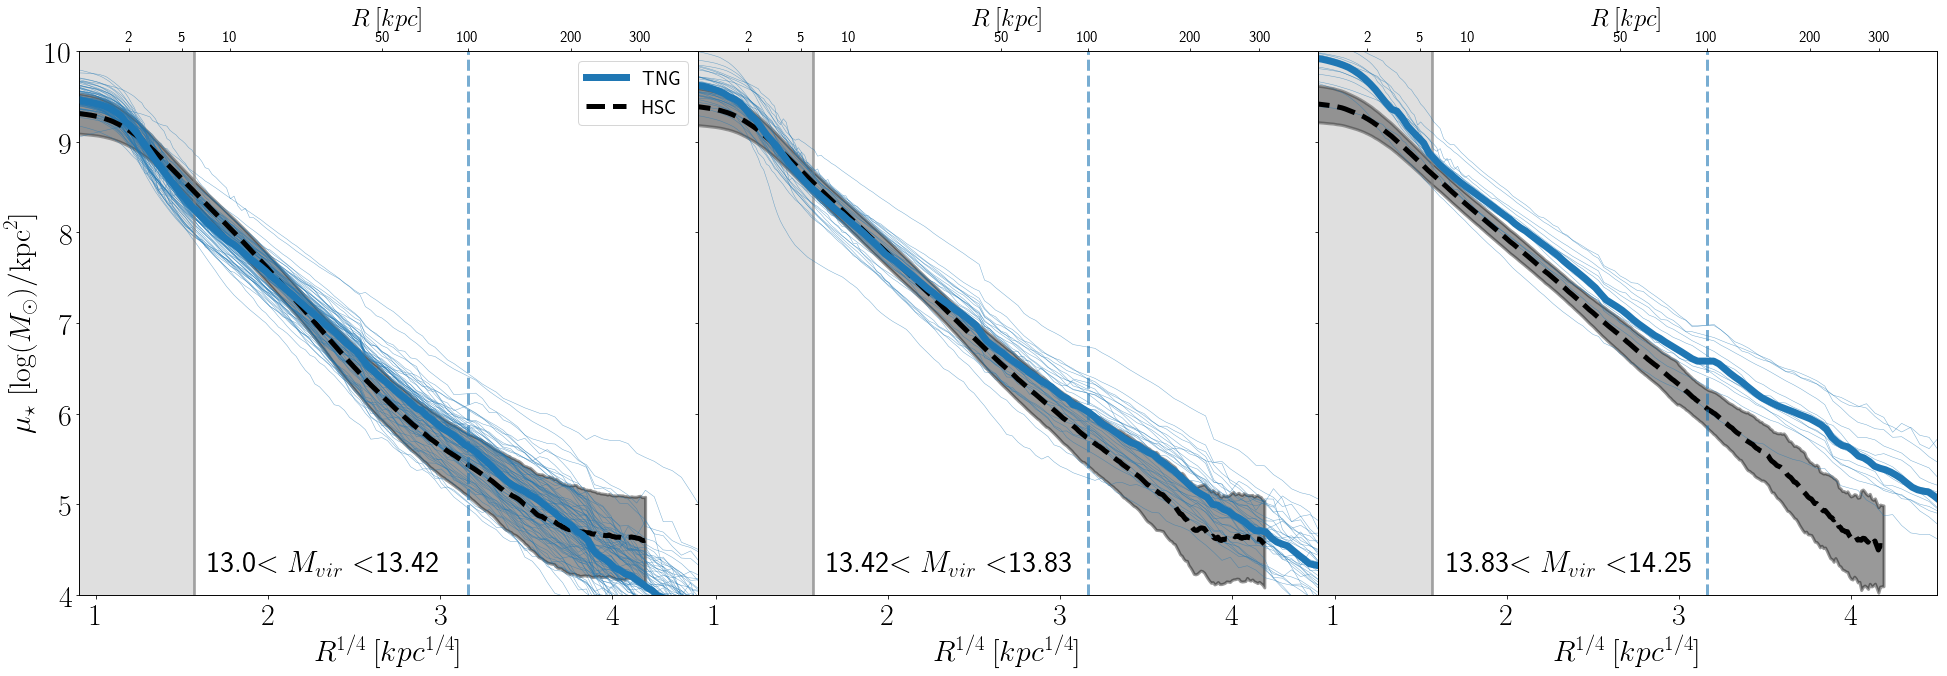

In [24]:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=False, figsize=(10*3, 10))
# fig.subplots_adjust(left=0.22, right=0.995, bottom=0.14, top=0.94, wspace=0.00, hspace=0.00)
fig=plt.figure(figsize=(10*6, 10))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(left=0.05, right=0.48, wspace=0.0)
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1])
gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.05, right=0.48, wspace=0.0)
ax3 = plt.subplot(gs2[0, -1])


######################################################################################################################
# plot
######################################################################################################################
#hsc
# ax1.plot(RSMA_COMMON, hscMedProf_116_118, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
# ax2.plot(RSMA_COMMON, hscMedProf_118_120, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
  


for mass, iso in zip(log_tng_m_vir, tng_isos): 
    
    if (mass<mass_bins[0]) or (mass>mass_bins[-1]):
        continue

    elif (mass>=mass_bins[0]) and (mass<mass_bins[1]):
        ngals1+=1

        tng_isos1.append(iso)

        ax1.plot((iso['sma_kpc']) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.6, 
                 label='_nolegend_', zorder=1)
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))
            
        
    elif (mass>=mass_bins[1]) and (mass<mass_bins[2]):
        ngals2+=1
        
        tng_isos2.append(iso)

        ax2.plot((iso['sma_kpc']) ** 0.25,
             np.log10(iso['intens_kpc'] )+ np.log10(0.7 ** 2.0), linewidth=0.5, c=u'#1f77b4', alpha=0.6, 
                 label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))
    
    elif (mass>=mass_bins[2]) and (mass<mass_bins[3]) :
        if (np.interp(6, iso['sma_kpc'], np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0)) > 8):#remove mergers:
            ngals3+=1

            tng_isos3.append(iso)

            ax3.plot((iso['sma_kpc']) ** 0.25,
                 np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0), linewidth=0.5, c=u'#1f77b4', alpha=0.6, 
                     label='_nolegend_')
                     #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


        
## median profiles for tng
median_sma1, median_mu1 = get_median_profile(tng_isos1, pixel_scale = 0, quantity='intens_kpc')
median_sma2, median_mu2 = get_median_profile(tng_isos2, pixel_scale = 0, quantity='intens_kpc')
median_sma3, median_mu3 = get_median_profile(tng_isos3, pixel_scale = 0, quantity='intens_kpc')

ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=7.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=5)
ax2.plot(median_sma2, median_mu2+ np.log10(0.7 ** 2.0), linewidth=7.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=5)
ax3.plot(median_sma3, median_mu3+ np.log10(0.7 ** 2.0), linewidth=7.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=5)


print ngals1, ngals2, ngals3

####################################################################################################################
#plot HSC profiles
# for profile in hsc_profiles[0][:100]:
#     ax1.plot(hsc_sma, profile, linewidth=0.5, c='k', linestyle='--',
#          alpha=0.2, zorder=1, label='_nolegend_')

#medians
hsc_median1 = np.nanmedian(hsc_profiles[0], axis=0)
hsc_median2 = np.nanmedian(hsc_profiles[1], axis=0)
hsc_median3 = np.nanmedian(hsc_profiles[2], axis=0)

ax1.plot(hsc_sma, hsc_median1, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
ax2.plot(hsc_sma, hsc_median2, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
ax3.plot(hsc_sma, hsc_median3, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')

#stds (masked_invalid to exclude infinities)
hsc_std1 = np.nanstd(np.ma.masked_invalid(hsc_profiles[0]),axis=0)
hsc_std2 = np.nanstd(np.ma.masked_invalid(hsc_profiles[1]),axis=0)
hsc_std3 = np.nanstd(np.ma.masked_invalid(hsc_profiles[2]),axis=0)

ax1.fill_between(hsc_sma, hsc_median1+hsc_std1, hsc_median1-hsc_std1, 
                 alpha=0.4, color='k', zorder=1, linewidth=3)
ax2.fill_between(hsc_sma, hsc_median2+hsc_std2, hsc_median2-hsc_std2, 
                 alpha=0.4, color='k', zorder=1, linewidth=3)
ax3.fill_between(hsc_sma, hsc_median3+hsc_std3, hsc_median3-hsc_std3, 
                 alpha=0.4, color='k', zorder=1, linewidth=3)
                 
######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 4.5)
ax1.set_ylim(4, 10)
ax2.set_xlim(0.9, 4.5)
ax2.set_ylim(4, 10)
ax3.set_xlim(0.9, 4.5)
ax3.set_ylim(4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='x', which='major', labelsize=30)
ax3.tick_params(axis='both', which='major', labelsize=30)

# #ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)
# ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#text label
ax1.text(1.65, 4.2, str(mass_bins[0]) + '$< M_{vir} <$' + str(round(mass_bins[1],2)), size=30)
ax2.text(1.65, 4.2, str(round(mass_bins[1],2)) + '$< M_{vir} <$' + str(round(mass_bins[2],2)), size=30)
ax3.text(1.65, 4.2, str(round(mass_bins[2],2)) + '$< M_{vir} <$' + str(mass_bins[3]), size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax2_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax2_twin.tick_params(axis='both', which='major', labelsize=15)
ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

x1, x2 = ax3.get_xlim()
ax3_twin = ax3.twiny()
ax3_twin.set_xlim(x1, x2)
ax3_twin.figure.canvas.draw()
ax3_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax3_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax3_twin.tick_params(axis='both', which='major', labelsize=15)
ax3_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)


######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax3.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
#ax3.set_ylabel(r'$M_{\star}( < r ) \: [ \log (M_{\odot})]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)
ax3.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax3.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)

######################################################################################################################
#grey out psf region
ax1.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax2.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax3.axvspan(0, 6**0.25, alpha=0.25, color='grey')
######################################################################################################################
#adjustments to ticks and space between subplots

#plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels()[0], visible=False)

#remove last label in x-axis of ax1 to prevent overlaping of labels with ax2
labels1 = [item.get_text() for item in ax2.get_xticklabels()[:-1]]
ax1.set_xticklabels(labels1)

#add a bit of space between subplots
# plt.tight_layout()

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/profiles_matched_by_halo_mass_TNG.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## plot for talk

In [31]:
Illustris_file_quick = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_stellarmaps_orig_11.2.hdf5'
illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_quick.pkl'
illustris_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_isos_quick.pkl'

illustris_masses = open_pkl(illustris_masses_file)
illustris_isos = open_pkl(illustris_isos_file)

f = h5py.File(Illustris_file_quick, 'r')
illustris_m_dm = np.log10(np.array(f['catgrp_Group_M_Crit200']))
map_size = f['config'].attrs['map_range_min']
n_pixels = f['config'].attrs['map_npixel']
pixel_scale_illustris=2 * (map_size/n_pixels)
f.close()


12


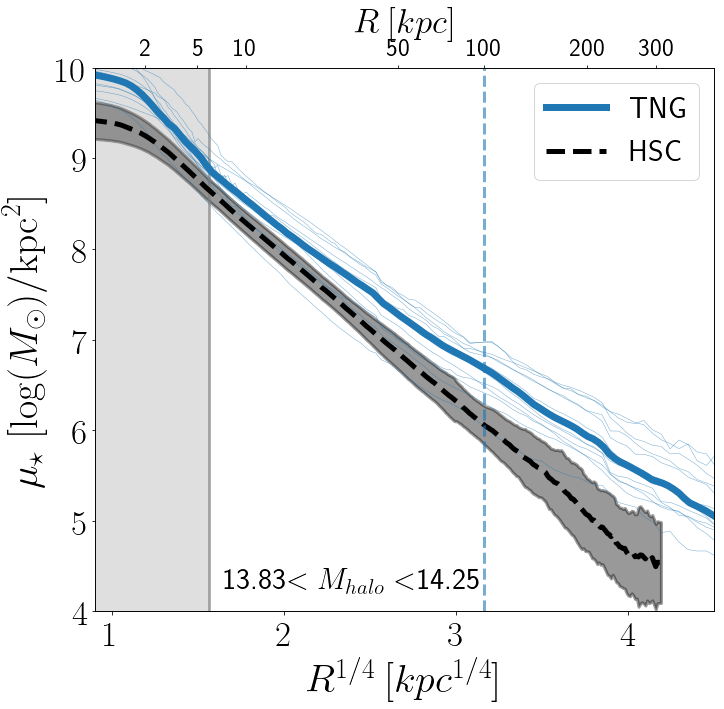

In [52]:
ngals_tng = 0
tng_isos3=[]


fig=plt.figure(figsize=(10*2, 10))
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=0.48, wspace=0.0)
ax2 = plt.subplot(gs1[0, 0])


######################################################################################################################
# plot
######################################################################################################################

for mass, iso in zip(tng_m_dm, tng_isos): 
    

    if (mass>=mass_bins[2]) and (mass<mass_bins[3]):
        sma = (iso['sma_kpc']) ** 0.25
        mu = np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0)
        
        if np.interp(6**0.25, sma, mu) > 8 :#remove mergers
            ngals_tng+=1

            tng_isos3.append(iso)

            ax2.plot((iso['sma_kpc'] ) ** 0.25,
                 np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0), linewidth=0.5, c=u'#1f77b4', alpha=0.6, 
                     label='_nolegend_')
                     #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))

print ngals_tng
        
## median profiles for tng
median_sma_tng, median_mu_tng = get_median_profile(tng_isos3, pixel_scale = 0, quantity='intens_kpc')

ax2.plot(median_sma_tng, median_mu_tng+ np.log10(0.7 ** 2.0), linewidth=7.0, c=u'#1f77b4', alpha=1, label='TNG',
         zorder=5)


####################################################################################################################
#plot HSC profiles
# for profile in hsc_profiles[0]:
#     ax1.plot(hsc_sma, profile, linewidth=0.5, c='grey',
#          alpha=0.1, zorder=8, label='HSC')

#medians
hsc_median3 = np.nanmedian(hsc_profiles[2], axis=0)

ax2.plot(hsc_sma, hsc_median3, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')

#stds (masked_invalid to exclude infinities)
hsc_std3 = np.nanstd(np.ma.masked_invalid(hsc_profiles[2]),axis=0)

ax2.fill_between(hsc_sma, hsc_median3+hsc_std3, hsc_median3-hsc_std3, 
                 alpha=0.4, color='k', zorder=1, linewidth=3)

######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax2.set_xlim(0.9, 4.5)
ax2.set_ylim(4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax2.tick_params(axis='both', which='major', labelsize=35)

# #ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)
# ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#text label
ax2.text(1.65, 4.2, str(round(mass_bins[2],2)) + '$< M_{halo} <$' + str(mass_bins[3]), size=30)

ax2.legend(fontsize=30)

#add twin x axis in kpc
x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax2_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax2_twin.tick_params(axis='both', which='major', labelsize=25)
ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=35)


######################################################################################################################

#axis labels and vertical lines
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=40)
#ax3.set_ylabel(r'$M_{\star}( < r ) \: [ \log (M_{\odot})]$', fontsize=30)
ax2.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=40)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)

######################################################################################################################
#grey out psf region
ax2.axvspan(0, 6**0.25, alpha=0.25, color='grey')
######################################################################################################################

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/talks/figures/matched_by_halo_mass_tng_large_bin.pdf',
            dpi=100, format='pdf', bbox_inches='tight')


plt.show()

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


22 46


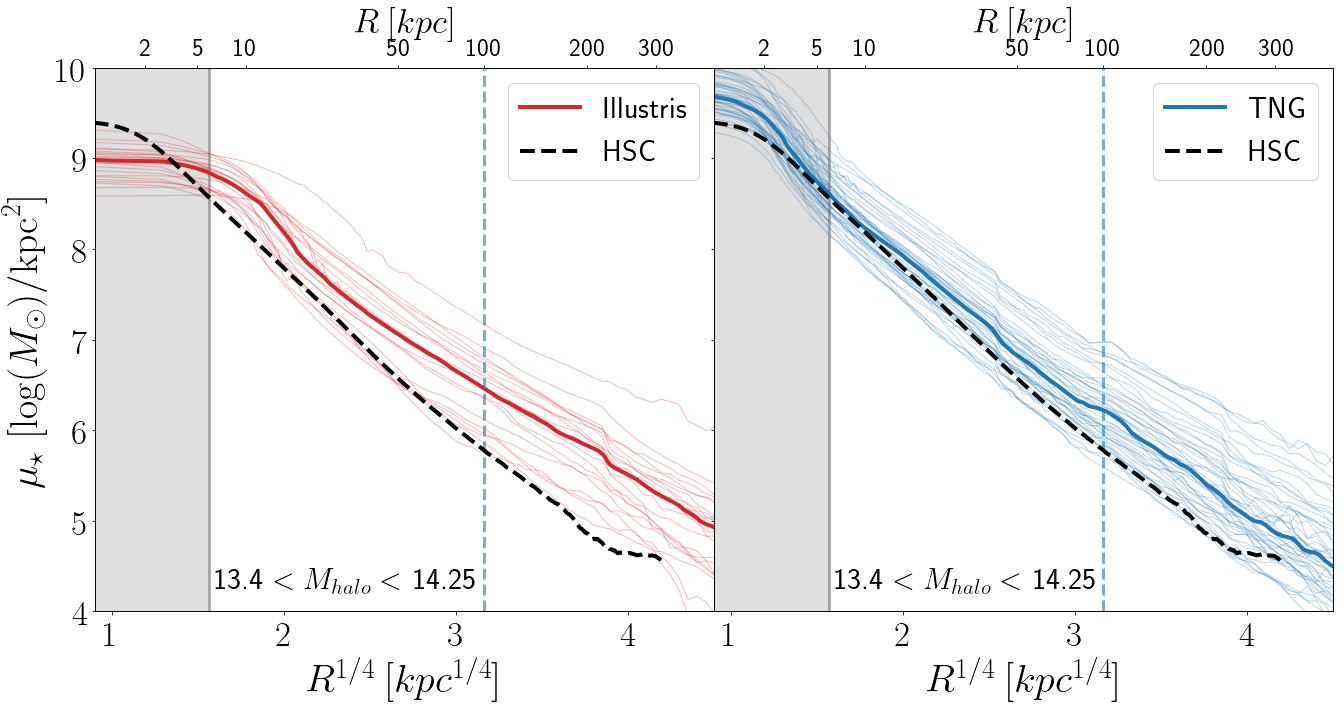

In [53]:
ngals_illustris, ngals_tng = 0,0
illustris_isos3=[]
tng_isos3=[]


fig=plt.figure(figsize=(10*4, 10))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(left=0.05, right=0.48, wspace=0.0)
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1])
gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.05, right=0.48, wspace=0.0)


######################################################################################################################
# plot
######################################################################################################################
#hsc
# ax1.plot(RSMA_COMMON, hscMedProf_116_118, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
# ax2.plot(RSMA_COMMON, hscMedProf_118_120, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
  
for mass, iso in zip(illustris_m_dm, illustris_isos): 
    

    if (mass>=mass_bins[2]) and (mass<mass_bins[3]):
        sma = (iso['sma'] * pixel_scale_illustris) ** 0.25
        mu = np.log10(iso['intens'] / (pixel_scale_illustris**2))+ np.log10(0.7 ** 2.0)
        
        if np.interp(1, sma, mu) > 8.5 :#remove mergers
            ngals_illustris+=1

            illustris_isos3.append(iso)

            ax1.plot((iso['sma'] * pixel_scale_illustris) ** 0.25,
                 np.log10(iso['intens'] / (pixel_scale_illustris**2))+ np.log10(0.7 ** 2.0), linewidth=1.0, c=u'#d62728', alpha=0.3, 
                     label='_nolegend_')
                     #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


        

for mass, iso in zip(tng_m_dm, tng_isos): 
    

    if (mass>=mass_bins[2]) and (mass<mass_bins[3]):
        sma = (iso['sma_kpc']) ** 0.25
        mu = np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0)
        
        if np.interp(6**0.25, sma, mu) > 8 :#remove mergers
            ngals_tng+=1

            tng_isos3.append(iso)

            ax2.plot((iso['sma_kpc'] ) ** 0.25,
                 np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0), linewidth=1.0, c=u'#1f77b4', alpha=0.3, 
                     label='_nolegend_')
                     #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))

print ngals_illustris, ngals_tng
        
## median profiles for tng
median_sma_illustris, median_mu_illustris = get_median_profile(illustris_isos3, pixel_scale = pixel_scale_illustris)
median_sma_tng, median_mu_tng = get_median_profile(tng_isos3, pixel_scale = 0, quantity='intens_kpc')

ax1.plot(median_sma_illustris, median_mu_illustris+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris')
ax2.plot(median_sma_tng, median_mu_tng+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='TNG')


####################################################################################################################
#plot HSC profiles
# for profile in hsc_profiles[0]:
#     ax1.plot(hsc_sma, profile, linewidth=0.5, c='grey',
#          alpha=0.1, zorder=8, label='HSC')

#medians
ax1.plot(hsc_sma, np.nanmedian(hsc_profiles[2], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')
ax2.plot(hsc_sma, np.nanmedian(hsc_profiles[2], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')

######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 4.5)
ax1.set_ylim(4, 10)
ax2.set_xlim(0.9, 4.5)
ax2.set_ylim(4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=35)
ax2.tick_params(axis='x', which='major', labelsize=35)

# #ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)
# ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#text label
ax1.text(1.6, 4.2, str(mass_bins[2]) + ' $ < M_{halo} < $ ' + str(mass_bins[3]), size=30)
ax2.text(1.6, 4.2, str(mass_bins[2]) + ' $ < M_{halo} < $ ' + str(mass_bins[3]), size=30)

ax1.legend(fontsize=30)
ax2.legend(fontsize=30)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax1_twin.tick_params(axis='both', which='major', labelsize=25)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=35)

x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax2_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax2_twin.tick_params(axis='both', which='major', labelsize=25)
ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=35)


######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=40)
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=40)
#ax3.set_ylabel(r'$M_{\star}( < r ) \: [ \log (M_{\odot})]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=40)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)

######################################################################################################################
#grey out psf region
ax1.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax2.axvspan(0, 6**0.25, alpha=0.25, color='grey')
######################################################################################################################
#adjustments to ticks and space between subplots

#plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels()[0], visible=False)

#remove last label in x-axis of ax1 to prevent overlaping of labels with ax2
labels1 = [item.get_text() for item in ax2.get_xticklabels()[:-1]]
ax1.set_xticklabels(labels1)

#add a bit of space between subplots
# plt.tight_layout()

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/talks/figures/matched_by_halo_mass.pdf',
            dpi=100, format='pdf', bbox_inches='tight')


plt.show()

# plot to large radii


/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


235


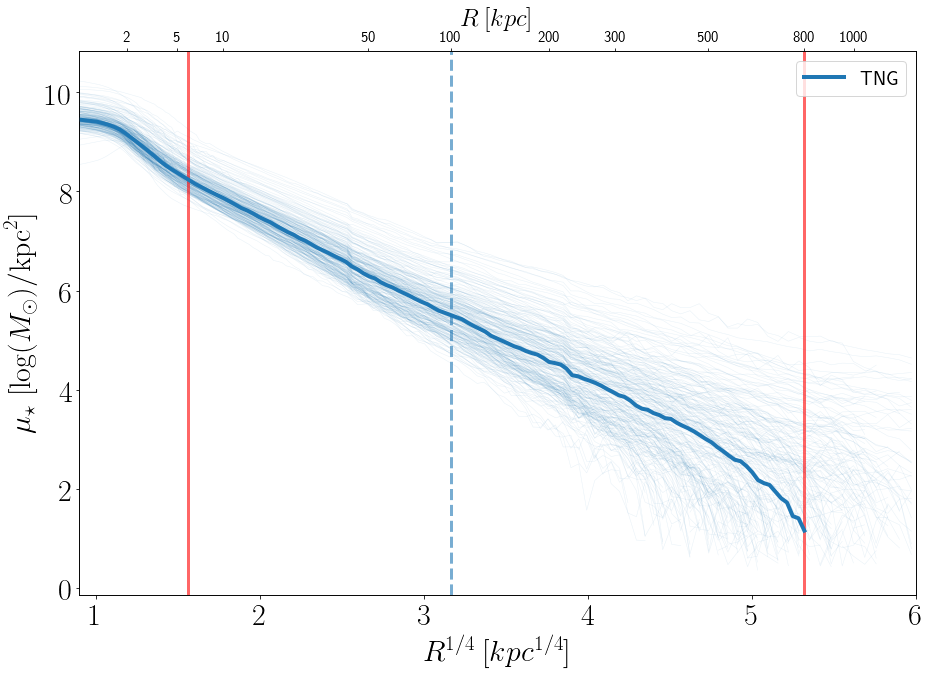

In [8]:
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################
#hsc
# ax1.plot(RSMA_COMMON, hscMedProf_116_118, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
# ax2.plot(RSMA_COMMON, hscMedProf_118_120, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
  


for iso in tng_isos:   
    

        ngals1+=1

        #tng_isos1.append(iso)

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.1, 
                 label='_nolegend_', zorder=1)
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


## median profiles for tng
median_sma1, median_mu1 = get_median_profile(tng_isos, quantity='intens_kpc', pixel_scale = pixel_scale_highres,
                                             rmax=800.**0.25)

ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=8)


print ngals1


######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 6)
#ax1.set_ylim(-2, 10)

# Labels
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_tng.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()